In [47]:
import pystac_client
import planetary_computer
import stackstac
import xrspatial.multispectral as ms

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [2]:
time_range = "2020-12-01/2020-12-31"
# bbox = [-122.2751, 47.5469, -121.9613, 47.7458]
bbox = [-124.41555786132812, 40.23088378906206, -124.36555786132813, 40.28088378906206]

search = catalog.search(collections=["landsat-c2-l2"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)


4

## Find the image with the lease cloud cover

In [49]:

selected_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])

## Covert to Stackstac object

In [53]:
%time stack = stackstac.stack(selected_item, bounds_latlon=bbox, epsg=4326)

CPU times: user 7.79 ms, sys: 220 µs, total: 8.01 ms
Wall time: 6.92 ms


In [54]:
stack

,Array,Chunk
Bytes,3.55 MiB,191.25 kiB
Shape,"(1, 19, 180, 136)","(1, 1, 180, 136)"
Count,57 Tasks,19 Chunks
Type,float64,numpy.ndarray


## Filter for RGB and cloud cover

In [80]:
rgb = stack.sel(band=["red", "green", "blue"]).compute()
rgb

<xarray.DataArray 'stackstac-0f046dc50ee4d0120b244053d9ff061a' (time: 1,
                                                                band: 3,
                                                                y: 180, x: 136)>
array([[[[ 7759.,  7844.,  7896., ...,  7097.,  5436.,  2661.],
         [ 7848.,  7947.,  7955., ...,  8217.,  7009.,  5154.],
         [ 7736.,  7860.,  7893., ...,  8260.,  6741.,  4360.],
         ...,
         [ 7200.,  7123.,  7104., ...,  6809.,  6835.,  6870.],
         [ 7190.,  7140.,  7139., ...,  6735.,  6823.,  6883.],
         [ 7258.,  7248.,  7184., ...,  6712.,  6836.,  6907.]],

        [[ 8560.,  8649.,  8733., ...,  9685.,  8609.,  6586.],
         [ 8660.,  8795.,  8764., ..., 10357.,  9423.,  8101.],
         [ 8605.,  8803.,  8739., ..., 10266.,  9193.,  7457.],
         ...,
         [ 7508.,  7448.,  7432., ...,  7385.,  7418.,  7471.],
         [ 7506.,  7463.,  7435., ...,  7391.,  7425.,  7466.],
         [ 7517.,  7505.,  7443., ...,  7337.,  7384.,  7431.]],

        [[ 8376.,  8500.,  8636., ...,  7152.,  5215.,  1959.],
         [ 8291.,  8442.,  8603., ...,  8331.,  6802.,  4684.],
         [ 8213.,  8250.,  8338., ...,  8441.,  6548.,  3772.],
         ...,
         [ 7213.,  7135.,  7126., ...,  6812.,  6833.,  6912.],
         [ 7155.,  7166.,  7166., ...,  6784.,  6839.,  6859.],
         [ 7225.,  7177.,  7215., ...,  6766.,  6841.,  6848.]]]])
Coordinates: (12/33)
  * time                         (time) datetime64[ns] 2020-12-29T18:57:56.17...
    id                           (time) <U31 'LC08_L2SP_046032_20201229_02_T1'
  * band                         (band) <U10 'red' 'green' 'blue'
  * x                            (x) float64 -124.4 -124.4 ... -124.4 -124.4
  * y                            (y) float64 40.28 40.28 40.28 ... 40.23 40.23
    gsd                          (band) object None None None
    ...                           ...
    title                        (band) <U68 'Red Band' 'Green Band' 'Blue Band'
    classification:bitfields     (band) object None None None
    common_name                  (band) object 'red' 'green' 'blue'
    center_wavelength            (band) object 0.65 0.56 0.48
    full_width_half_max          (band) object 0.04 0.06 0.06
    epsg                         int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-124.41568463677132, 40.230...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-124.42|\n| 0.00,-0.00, 40.28|\n| 0.00, 0.00...
    resolution_xy:  (0.00036968843305373866, 0.0002784675293554528)

In [82]:
rgb = rgb.median(dim="time").compute()

In [71]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.29650ac04bee40369bb000dcd576bf0c/status


In [93]:
rgb.max()

<xarray.DataArray 'stackstac-0f046dc50ee4d0120b244053d9ff061a' ()>
array(27569.)
Coordinates: (12/20)
    landsat:collection_category  <U2 'T1'
    proj:shape                   object {7931, 7811}
    landsat:wrs_type             <U1 '2'
    landsat:correction           <U4 'L2SP'
    created                      <U27 '2022-05-06T18:04:39.383589Z'
    sci:doi                      <U16 '10.5066/P9OGBGM6'
    ...                           ...
    landsat:cloud_cover_land     float64 61.57
    proj:epsg                    int64 32610
    instruments                  object {'tirs', 'oli'}
    landsat:collection_number    <U2 '02'
    landsat:scene_id             <U21 'LC80460322020364LGN00'
    epsg                         int64 4326

In [83]:
import ipyleaflet

m = ipyleaflet.Map()
m.center = (bbox[1] + bbox[3])/2 , (bbox[0] + bbox[2])/2
m.zoom = 10
m.layout.height = "700px"
m


Map(center=[40.25588378906206, -124.39055786132812], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [89]:
stackstac.add_to_map(rgb, m, "s2", range=[0, 300000])

TileLayer(name='s2', options=['attribution', 'bounds', 'detect_retina', 'max_native_zoom', 'max_zoom', 'min_na…

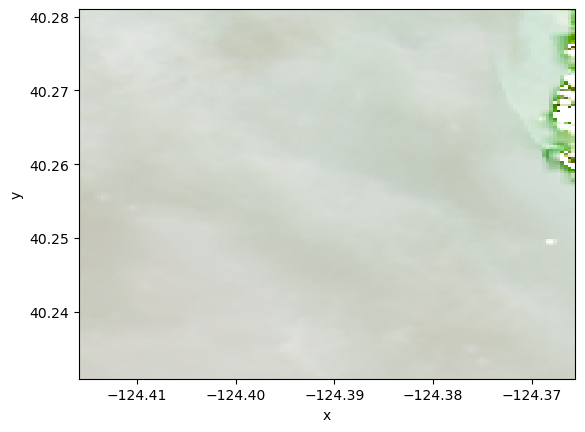

In [96]:
## Get an RGB image from the stackstac
image = ms.true_color(*rgb)  # expects red, green, blue DataArrays
image.plot.imshow();

In [101]:
aoi_rgb = rgb.to_numpy()
aoi_rgb.shape

(3, 180, 136)

In [110]:
import numpy as np
np.nanmax(aoi_rgb), np.nanmin(aoi_rgb)

(27569.0, 4.0)

In [24]:
bbox

[-124.41555786132812,
 40.23088378906206,
 -124.36555786132813,
 40.28088378906206]

array('d', [-118.86555786132844, -118.86555786132844, -118.91555786132844, -118.91555786132844, -118.86555786132844]) array('d', [37.180883789062236, 37.23088378906223, 37.23088378906223, 37.180883789062236, 37.180883789062236])


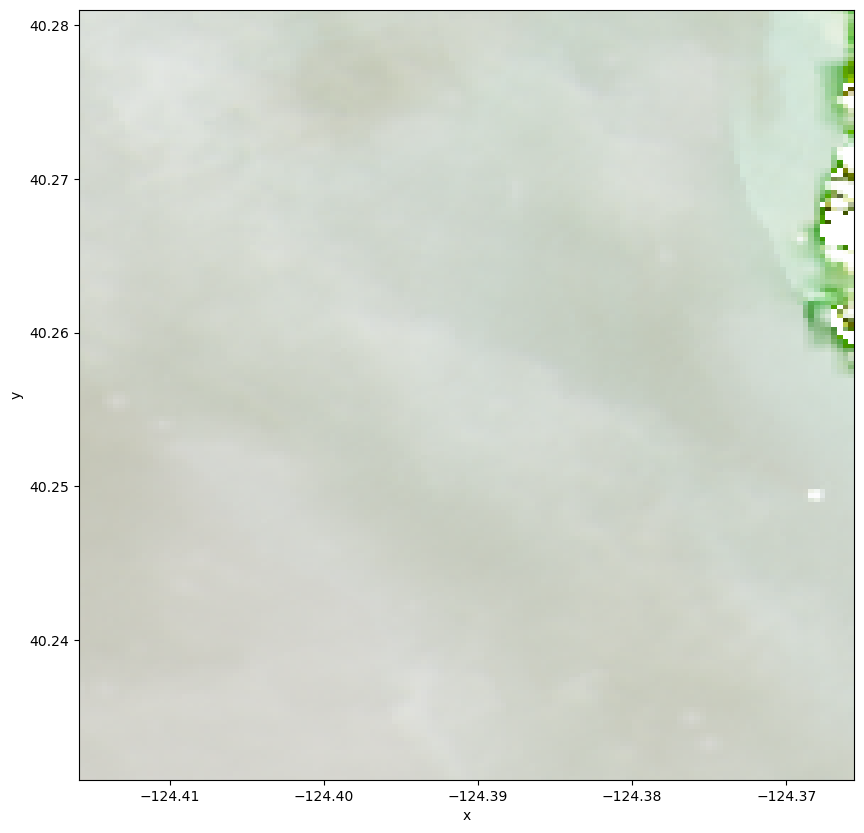

In [99]:
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
coords = ((-118.86555786132844, 37.180883789062236),(-118.86555786132844, 37.23088378906223), \
            (-118.91555786132844, 37.23088378906223),(-118.91555786132844, 37.180883789062236),(-118.86555786132844, 37.180883789062236))
bbox_poly = Polygon(coords)
bbox_poly
x,y = bbox_poly.exterior.xy
print(x,y)
ax.plot(x,y)
image.plot.imshow(ax=ax)
# df_test = gpd.GeoDataFrame(geometry=Polygon(coords), crs='4326')
# df_test.plot()
# bbox_poly